# Seeing if `climpred` will suit my needs

In [1]:
import glob

import dask

import cftime

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

import climpred  # Currently using local forked version (editible)
from climpred import HindcastEnsemble

dask.config.set(**{"array.slicing.split_large_chunks": False})

In [2]:
from src.utils import utils

In [3]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [4]:
xr.set_options(keep_attrs=True)

# Cluster

In [5]:
from dask.distributed import Client
from dask_jobqueue import PBSCluster

walltime = "02:00:00"
cores = 24
memory = "96GB"
cluster = PBSCluster(
    walltime=str(walltime),
    cores=cores,
    memory=str(memory),
    job_extra=[
        "-l ncpus=" + str(cores),
        "-l mem=" + str(memory),
        "-P xv83",
        "-l jobfs=100GB",
        "-l storage=gdata/xv83",
    ],
    local_directory="$PBS_JOBFS",
    # env_extra=['export MALLOC_TRIM_THRESHOLD_="0"'],
    header_skip=["select"],
)

/g/data/xv83/users/ds0092/software/miniconda3/envs/cafe-f6_analysis/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [6]:
cluster.scale(jobs=1)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.6.48.69:8787/status,
Dashboard: http://10.6.48.69:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.48.69:41287,Workers: 0
Dashboard: http://10.6.48.69:8787/status,Total threads: 0
Started: 1 minute ago,Total memory: 0 B


# Prepare some data - CAFE hindcasts
Use only the November forecasts, due to issue with changing executable for May forecasts

In [57]:
data_dir = "/g/data/xv83/dcfp/CAFE-f6"
realm = "atmos_isobaric_month.zarr.zip"
variable = "t_ref"

files = sorted(glob.glob(f"{data_dir}/c5-d60-pX-f6-????11??/{realm}"))


def preprocess_CAFEf6_monthly_to_annual(ds):
    """Preprocessing steps for CAFE-f6 data"""
    ds = utils.round_to_start_of_month(ds, dim="time")
    ds = utils.convert_time_to_lead(ds)

    # Truncate lats so that forecasts run on different systems can be stacked
    ds = utils.truncate_latitudes(ds)

    return ds


f6_hcst = xr.open_mfdataset(
    files,
    compat="override",
    preprocess=preprocess_CAFEf6_monthly_to_annual,
    engine="zarr",
    coords="minimal",
    parallel=True,
)[variable]

# Focus on global and ensemble mean for now
def global_mean(ds, area):
    sl = {"lat": slice(-90, 90)}
    return ds.sel(sl).weighted(area).mean(["lat", "lon"])


cafe_area = f6_hcst["area"]

# Convert to annual data
f6_hcst_monthly = global_mean(f6_hcst, cafe_area).mean("ensemble").compute()
f6_hcst = (
    global_mean(utils.coarsen_monthly_to_annual(f6_hcst, dim="lead"), cafe_area)
    .mean("ensemble")
    .compute()
)

In [58]:
data_dir = "/g/data/xv83/dcfp/CAFE-f5/NOV/"
realm = "atmos_isobaric_month.zarr.zip"
variable = "t_ref"

f5_hcst = xr.open_dataset(f"{data_dir}{realm}", engine="zarr", chunks={})[variable]
f5_hcst = utils.coarsen_monthly_to_annual(f5_hcst, dim="lead_time")
f5_hcst = f5_hcst.rename({"init_date": "init", "lead_time": "lead"})
f5_hcst = utils.round_to_start_of_month(f5_hcst, dim=["init", "time"])

# Focus on global mean for now
f5_hcst = global_mean(f5_hcst, cafe_area).mean("ensemble").compute()

# Prepare some data - CAFE historical

In [59]:
data_dir = "/g/data/xv83/users/ds0092/data/CAFE/historical/WIP"
realm = "atmos_isobaric_month.zarr.zip"

cafe_hist = utils.truncate_latitudes(
    xr.open_zarr(f"{data_dir}/c5-d60-pX-hist-19601101/ZARR/{realm}")
)["t_ref"]
cafe_ctrl = utils.truncate_latitudes(
    xr.open_zarr(f"{data_dir}/c5-d60-pX-ctrl-19601101/ZARR/{realm}")
)["t_ref"]

cafe_ctrl_drift = (
    cafe_ctrl.mean("ensemble").groupby("time.month").map(lambda x: x - x.mean(["time"]))
)
cafe_hist = cafe_hist - cafe_ctrl_drift
# cafe_hist = cafe_hist.groupby("time.month") + cafe_ctrl_clim

cafe_hist = utils.round_to_start_of_month(cafe_hist, dim="time")

# Process annual means to match hcst dataset
cafe_hist = utils.coarsen_monthly_to_annual(cafe_hist, f5_hcst.init[0])

# Focus on global mean for now
cafe_hist = global_mean(cafe_hist, cafe_area).mean("ensemble").compute()

/g/data/xv83/users/ds0092/software/miniconda3/envs/cafe-f6_analysis/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 80 times more chunks
  return self.array[key]
/g/data/xv83/users/ds0092/software/miniconda3/envs/cafe-f6_analysis/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 80 times more chunks
  return self.array[key]
/g/data/xv83/users/ds0092/software/miniconda3/envs/cafe-f6_analysis/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 80 times more chunks
  return self.array[key]


# Prepare some data - JRA55

In [60]:
jra55_monthly = utils.truncate_latitudes(
    xr.open_zarr(
        "/g/data/xv83/reanalyses/JRA55/surface_month_cafe-grid.zarr.zip",
        use_cftime=True,
    )
)["TMP_GDS0_HTGL"].compute()

jra55_monthly = jra55_monthly.rename({"initial_time0_hours": "time"})
# Force to Julian calendar
jra55_monthly = jra55_monthly.assign_coords(
    {
        "time": xr.cftime_range(
            start=jra55_monthly.time[0].item().strftime(),
            end=jra55_monthly.time[-1].item().strftime(),
            freq="MS",
            calendar="julian",
        )
    }
)

# Process annual means to match hcst dataset
jra55 = utils.coarsen_monthly_to_annual(jra55_monthly, f5_hcst.init[0])

# Focus on global mean for now
jra55_monthly = global_mean(jra55_monthly, cafe_area).compute()
jra55 = global_mean(jra55, cafe_area).compute()

# Calculate anomalies for pre and post 1992 separately to try to account for change to CAFE60 bias-correction scheme

In [11]:
f6_hcst_clim_all = f6_hcst.mean("init")
f6_hcst_anom_all = f6_hcst - f6_hcst_clim_all

In [12]:
period = [cftime.DatetimeJulian(1991, 10, 1), cftime.DatetimeJulian(2021, 10, 1)]

f6_hcst_clim_period = f6_hcst.where(
    (f6_hcst.time >= period[0]) & (f6_hcst.time <= period[1])
).mean("init")
f6_hcst_anom_period = f6_hcst - f6_hcst_clim_period

In [29]:
transition_year = 1992
f6_hcst_clim_pre1992 = f6_hcst.sel(init=slice(None, str(transition_year - 1))).mean(
    "init"
)
f6_hcst_clim_post1992 = f6_hcst.sel(init=slice(str(transition_year), None)).mean("init")
f6_hcst_anom_splitf6 = xr.concat(
    (
        f6_hcst.sel(init=slice(None, str(transition_year - 1))) - f6_hcst_clim_pre1992,
        f6_hcst.sel(init=slice(str(transition_year), None)) - f6_hcst_clim_post1992,
    ),
    dim="init",
)

In [30]:
transition_year = 1992
f5_hcst_clim_pre1992 = f5_hcst.sel(init=slice("1964", str(transition_year - 1))).mean(
    "init"
)
f5_hcst_clim_post1992 = f5_hcst.sel(init=slice(str(transition_year), "2020")).mean(
    "init"
)
f6_hcst_anom_splitf5 = xr.concat(
    (
        f6_hcst.sel(init=slice(None, str(transition_year - 1))) - f5_hcst_clim_pre1992,
        f6_hcst.sel(init=slice(str(transition_year), None)) - f5_hcst_clim_post1992,
    ),
    dim="init",
)

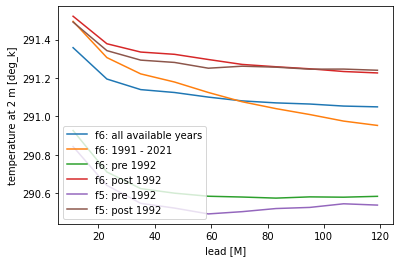

In [31]:
f6_hcst_clim_all.plot(label="f6: all available years")

f6_hcst_clim_period.plot(label="f6: 1991 - 2021")

f6_hcst_clim_pre1992.plot(label=f"f6: pre {transition_year}")
f6_hcst_clim_post1992.plot(label=f"f6: post {transition_year}")

f5_hcst_clim_pre1992.plot(label=f"f5: pre {transition_year}")
f5_hcst_clim_post1992.plot(label=f"f5: post {transition_year}")

plt.legend()

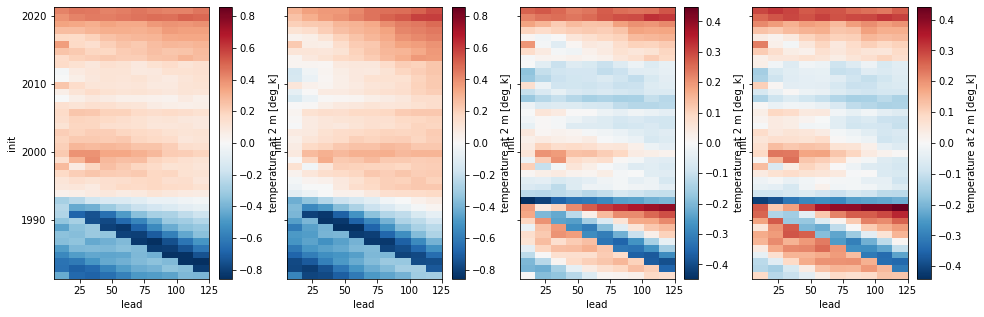

In [32]:
fig = plt.figure(figsize=(16, 5))
axs = fig.subplots(1, 4, sharey=True)

f6_hcst_anom_all.plot(ax=axs[0])
f6_hcst_anom_period.plot(ax=axs[1])
f6_hcst_anom_splitf6.plot(ax=axs[2])
f6_hcst_anom_splitf5.plot(ax=axs[3])

### That doesn't look very good. What about correcting for the biases on a sliding window basis, using the previous 12 years of data?

e.g. 
- for the 1981 forecast, biases are calculated over the period 1970-1981 at all leads
- for the 2020 forecast, biases are calculated over the period 2009-2020 at all leads 

This is a fair approach, but it will have to use the f5 forecasts to calculate the biases

In [137]:
n_years = 12

objs = []
for init in f6_hcst.init:
    f6 = f6_hcst.sel(init=[init.item()])

    # Calculate the bias
    clim_range = [
        f6.get_index("init").shift(-(12 * n_years), "MS").item(),
        f6.get_index("init").item(),
    ]
    f5_clim = f5_hcst.where(
        (f5_hcst.time >= clim_range[0]) & (f5_hcst.time <= clim_range[1])
    ).mean("init")
    jra_clim = jra55.where(
        (jra55.time >= clim_range[0]) & (jra55.time <= clim_range[1])
    ).mean("time")
    bias = f5_clim - jra_clim

    objs.append(f6 - bias)

f6_hcst_bc = xr.concat(objs, dim="init")

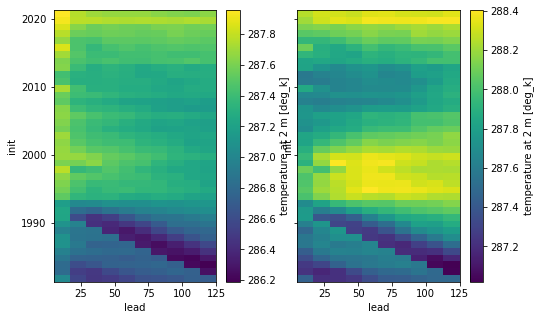

In [138]:
fig = plt.figure(figsize=(8, 5))
axs = fig.subplots(1, 2, sharey=True)

f6_hcst.plot(ax=axs[0])
f6_hcst_bc.plot(ax=axs[1])

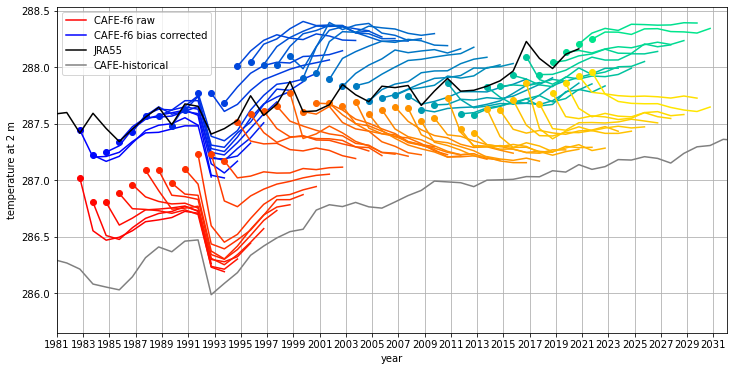

In [139]:
from matplotlib.pyplot import cm
from matplotlib.dates import date2num

fig = plt.figure(figsize=(12, 6))

color = cm.autumn(np.linspace(0, 0.9, len(f6_hcst.init)))
color_bc = cm.winter(np.linspace(0, 0.9, len(f6_hcst.init)))
for idx, (i, c, c_bc) in enumerate(zip(f6_hcst.init, color, color_bc)):
    if idx == 0:
        label = "CAFE-f6 raw"
        label_bc = "CAFE-f6 bias corrected"
    else:
        label = label_bc = "_nolabel_"

    hcst = f6_hcst.sel(init=i)
    plt.plot(hcst.time[0], hcst[0], color=c, marker="o", label="_nolabel_")
    plt.plot(hcst.time, hcst, color=c, linestyle="-", label=label)

    hcst_bc = f6_hcst_bc.sel(init=i)
    plt.plot(hcst_bc.time[0], hcst_bc[0], color=c_bc, marker="o", label="_nolabel_")
    plt.plot(hcst_bc.time, hcst_bc, color=c_bc, linestyle="-", label=label_bc)

plt.plot(jra55.time, jra55, color="black", label="JRA55")
plt.plot(cafe_hist.time, cafe_hist, color="grey", label="CAFE-historical")

# jra55_Nov = jra55_monthly.where(jra55_monthly.time.dt.month == 11, drop=True)
# plt.plot(jra55_Nov.time, jra55_Nov, color="black", zorder=12)

ticks = xr.cftime_range(
    start="1981-01-01", end="2032-01-01", freq="2AS", calendar="julian"
)
plt.xticks(
    ticks.values,
    labels=ticks.year,
)
plt.xlim(cftime.DatetimeJulian(1981, 1, 1), cftime.DatetimeJulian(2032, 1, 1))
plt.xlabel("year")
plt.ylabel(f6_hcst.attrs["long_name"])
plt.grid()
plt.legend()

### Not great either. Is just using the f6 climatology over the max consistent period really that bad?
Perhaps the different behaviour in Damiens plots prior to 1992 is actually coming from our model's over-sensitivity to volcanos, rather than a large change in initial conditions

In [158]:
period = [cftime.DatetimeJulian(1991, 10, 1), cftime.DatetimeJulian(2020, 10, 1)]

f6_clim = f6_hcst.where((f6_hcst.time >= period[0]) & (f6_hcst.time <= period[1])).mean(
    "init"
)
jra_clim = jra55.where((jra55.time >= period[0]) & (jra55.time <= period[1])).mean(
    "time"
)
bias = f6_clim - jra_clim

f6_hcst_bc = f6_hcst - bias

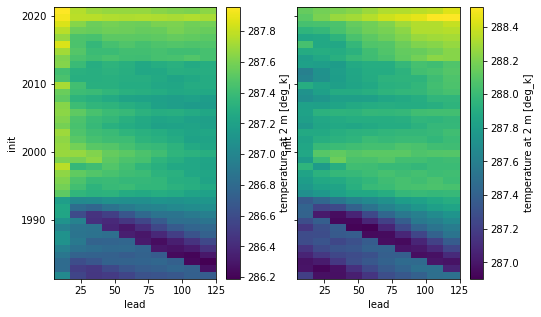

In [159]:
fig = plt.figure(figsize=(8, 5))
axs = fig.subplots(1, 2, sharey=True)

f6_hcst.plot(ax=axs[0])
f6_hcst_bc.plot(ax=axs[1])

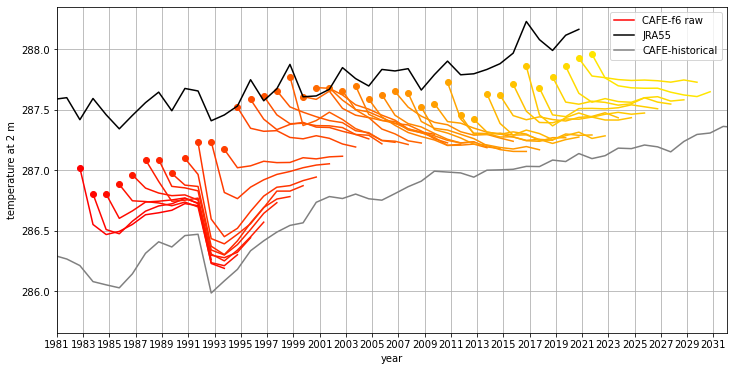

In [163]:
from matplotlib.pyplot import cm
from matplotlib.dates import date2num

fig = plt.figure(figsize=(12, 6))

color = cm.autumn(np.linspace(0, 0.9, len(f6_hcst.init)))
color_bc = cm.winter(np.linspace(0, 0.9, len(f6_hcst.init)))
for idx, (i, c, c_bc) in enumerate(zip(f6_hcst.init, color, color_bc)):
    if idx == 0:
        label = "CAFE-f6 raw"
        label_bc = "CAFE-f6 bias corrected"
    else:
        label = label_bc = "_nolabel_"

    hcst = f6_hcst.sel(init=i)
    plt.plot(hcst.time[0], hcst[0], color=c, marker="o", label="_nolabel_")
    plt.plot(hcst.time, hcst, color=c, linestyle="-", label=label)

    # hcst_bc = f6_hcst_bc.sel(init=i)
    # plt.plot(hcst_bc.time[0], hcst_bc[0], color=c_bc, marker="o", label="_nolabel_")
    # plt.plot(hcst_bc.time, hcst_bc, color=c_bc, linestyle="-", label=label_bc)

plt.plot(jra55.time, jra55, color="black", label="JRA55")
plt.plot(cafe_hist.time, cafe_hist, color="grey", label="CAFE-historical")

ticks = xr.cftime_range(
    start="1981-01-01", end="2032-01-01", freq="2AS", calendar="julian"
)
plt.xticks(
    ticks.values,
    labels=ticks.year,
)
plt.xlim(cftime.DatetimeJulian(1981, 1, 1), cftime.DatetimeJulian(2032, 1, 1))
plt.xlabel("year")
plt.ylabel(f6_hcst.attrs["long_name"])
plt.grid()
plt.legend()

# What about fitting an exponential 
Of the form $D(l>0) = D(l=0) \exp(-A l)$ where $D = F - H$ is the deviation between the forecast, $F$, and the historical run, $H$; and $l$ is the lead time.

#### Subtract the historical run off the forecasts

In [194]:
res = []
for i in f6_hcst.init:
    hcst = f6_hcst.sel(init=i).swap_dims({"lead": "time"})
    res.append((hcst - cafe_hist).swap_dims({"time": "lead"}))

f6_D = xr.concat(res, dim="init")

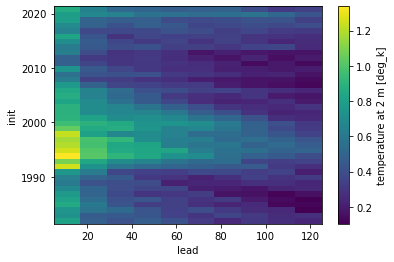

In [195]:
f6_D.plot()

In [246]:
from scipy.optimize import leastsq


def multiple_reg(x, y, f, const, params0, **kwargs):
    """Do same non-linear regression on multiple curves"""

    def leastsq_func(params, *args):
        x, y = args[:2]
        const = args[2:]
        yfit = []
        for i in range(len(x)):
            yfit = np.append(yfit, f(x[i], *const[i], *params))
        return y - yfit

    # turn const into 2d-array if 1d is given
    const = np.asarray(const)
    if len(const.shape) < 2:
        const = np.atleast_2d(const).T

    # ensure that y is flat and x is nested
    if hasattr(y[0], "__len__"):
        y = [item for sublist in y for item in sublist]
    if not hasattr(x[0], "__len__"):
        x = np.tile(x, (len(const), 1))
    x_ = [item for sublist in x for item in sublist]
    assert len(x_) == len(y)

    # collect all arguments in a tuple
    y = np.asarray(y)
    args = [x, y] + list(const)
    args = tuple(args)  # doesn't work if args is a list!!

    return leastsq(leastsq_func, params0, args=args, **kwargs)

In [287]:
range(1, 10)

range(1, 10)

In [289]:
def fit(x, D0, A):
    return D0 * np.exp(-A * x)


A, _ = multiple_reg(range(1, 10), f6_D.values[:, 1:], fit, f6_D.values[:, 0], 0.05)

In [ ]:
plt.figure(figsize=(15, 6))

color = cm.winter(np.linspace(0, 0.9, len(f6_hcst.init)))
for i, c in zip(f6_D.init, color):
    f6_D_ts = f6_D.sel(init=i).swap_dims({"lead": "time"})
    plt.plot(f6_D_ts.time, f6_D_ts, color=c)

    x = range(1, 10)
    y = fit(x, f6_D_ts.values[0], A)
    fit_y = np.concatenate(([f6_D_ts.values[0]], y))
    plt.plot(f6_D_ts.time, fit_y, color="k", linestyle="--")

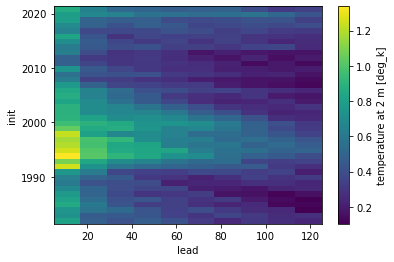

In [193]:
from scipy.optimize import leastsq

def fit(x, x0, A):
    return np.exp(-A * x)

#+++++++++++++++++++++++++++++++++++++++++++++
def leastsq_func(params, *args):
  cc=args[0]   #number of curves
  incs=args[1] #number of points 
  x=args[2]
  y=args[3]
  T=args[4:]

  A=params[0]
  n=params[1]
  m=params[2]

  yfit=numpy.empty(x.shape)
  for i in range(cc):
    v=i*incs
    b=(i+1)*incs
    if b<cc:
     yfit[v:b]=fit(x[v:b],T[i],A,n,m)
    else:
     yfit[v:]=fit(x[v:],T[i],A,n,m)

  return y-yfit
#+++++++++++++++++++++++++++++++++++++++++++++
Ts  =[10,100,1000,10000]    #4 T-values for 4 curves
incs=10                     #10 datapoints in each curve
x=["measured data"]   #all 40 x-values
y=["measrued data"]   #all 40 y-values
x=numpy.array(x)   
y=numpy.array(y)   

params0=[0.001,1.01,-0.8]   #parameter guess

args=[len(Ts),incs,x,y]
for c in Ts:
  args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

result=leastsq(leastsq_func, params0, args=args)


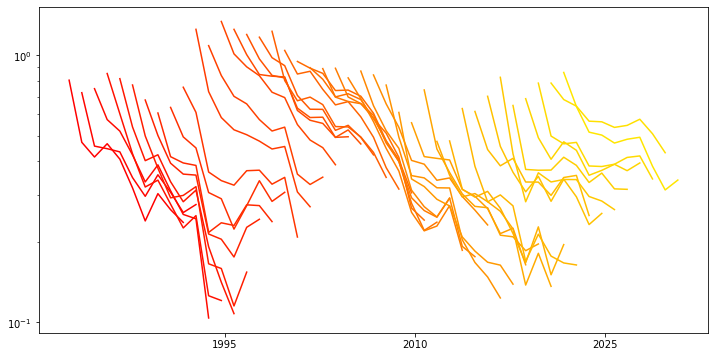

In [167]:
from matplotlib.pyplot import cm
from matplotlib.dates import date2num

fig = plt.figure(figsize=(12, 6))

color = cm.autumn(np.linspace(0, 0.9, len(f6_hcst.init)))
color_bc = cm.winter(np.linspace(0, 0.9, len(f6_hcst.init)))
for idx, (i, c, c_bc) in enumerate(zip(f6_hcst.init, color, color_bc)):
    if idx == 0:
        label = "CAFE-f6 raw"
        label_bc = "CAFE-f6 bias corrected"
    else:
        label = label_bc = "_nolabel_"

    hcst = f6_hcst.sel(init=i).swap_dims({"lead": "time"})
    plt.plot(hcst.time, hcst - cafe_hist, color=c, linestyle="-", label=label)

    # hcst_bc = f6_hcst_bc.sel(init=i)
    # plt.plot(hcst_bc.time[0], hcst_bc[0], color=c_bc, marker="o", label="_nolabel_")
    # plt.plot(hcst_bc.time, hcst_bc, color=c_bc, linestyle="-", label=label_bc)

# plt.plot(jra55.time, jra55, color="black", label="JRA55")
# plt.plot(cafe_hist.time, cafe_hist, color="grey", label="CAFE-historical")

# ticks = xr.cftime_range(
#     start="1981-01-01", end="2032-01-01", freq="2AS", calendar="julian"
# )
# plt.xticks(
#     ticks.values,
#     labels=ticks.year,
# )
# plt.xlim(cftime.DatetimeJulian(1981, 1, 1), cftime.DatetimeJulian(2032, 1, 1))
# plt.xlabel("year")
# plt.ylabel(f6_hcst.attrs["long_name"])
# plt.grid()
# plt.legend()
plt.yscale("log")

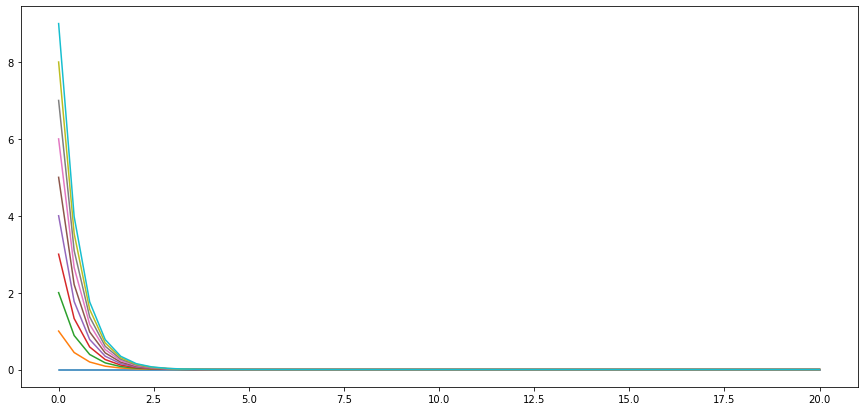

In [183]:
plt.figure(figsize=(15, 7))

S = 2

for i in range(0, 10):
    t = np.linspace(0, 20)
    y = i * np.exp(-S * t)

    plt.plot(x, y)

### What about using the Kharin approach?
This would prbably help, but not for the right reason. The Kharin approach is designed to account for differences in drift between the model and real world, not for changes in initialisation strategy...

### Why is the initial condition so different than JRA55?
See `why_does_lead0_GMST_not_match_jra55.ipynb`

### Prep for `climpred`

In [ ]:
f6_hcst = f6_hcst.rename({"ensemble": "member"})
f6_hcst["lead"].attrs["units"] = "months"
f6_hcst = f6_hcst.drop("time")

f6_CHUNKS = {"init": -1, "lead": 1}
f6_hcst = f6_hcst.chunk(f6_CHUNKS).persist()

In [ ]:
hindcast_raw = HindcastEnsemble(f6_hcst)

### Remove the lead-dependent bias

In [ ]:
hindcast = hindcast_raw.remove_bias(alignment="same_verifs", how="additive_mean")

# Prep data for `climpred`

In [89]:
HIST_CHUNKS = {"time": -1}
cafe_hist_ts = cafe_hist_ts.chunk(HIST_CHUNKS).persist()

In [90]:
cafe_hcst_gbl = cafe_hcst.weighted(cafe_hcst["area"]).mean(["lat", "lon", "member"])
cafe_hist_gbl = cafe_hist_ts.weighted(cafe_hist_ts["area"]).mean(
    ["lat", "lon", "member"]
)
jra55_gbl = jra55.weighted(cafe_hcst["area"]).mean(["lat", "lon"])

hindcast = HindcastEnsemble(cafe_hcst_gbl)
hindcast = hindcast.add_uninitialized(cafe_hist_gbl)
hindcast = hindcast.add_observations(jra55_gbl)

<AxesSubplot:xlabel='validity time', ylabel='Temperature [K]'>

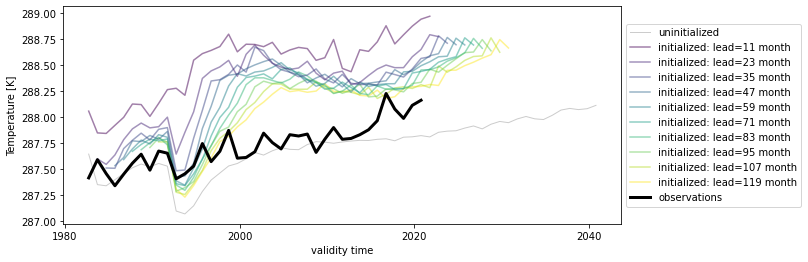

In [91]:
hindcast.plot()

# Remove the bias

In [95]:
hindcast_bc = hindcast.remove_bias(alignment="same_verifs", how="additive_mean")

<AxesSubplot:xlabel='validity time', ylabel='Temperature [K]'>

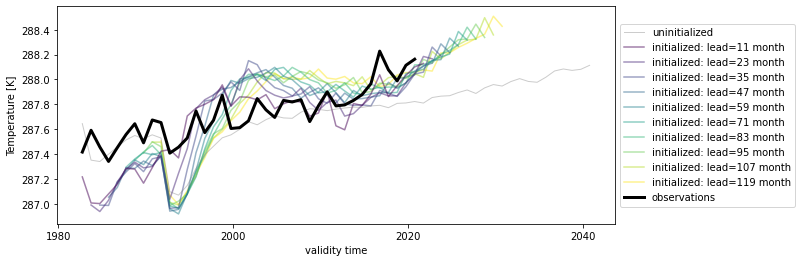

In [103]:
hindcast_bc.plot()

# Play with `climpred`

In [104]:
rmse = hindcast_bc.verify(
    reference="uninitialized",
    metric="rmse",
    comparison="e2o",
    alignment="same_verifs",
    dim=["init"],
)

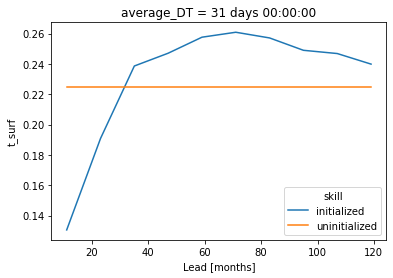

In [108]:
rmse["t_surf"].plot.line(x="lead")

In [10]:
cafe_hist = stack_by_init_date(
    cafe_hist_ts.chunk({"time": -1, "lat": 1}),
    init_dates=cafe_hcst["init"],
    n_lead_steps=cafe_hcst.sizes["lead"],
)

cafe_hist = cafe_hist.chunk(HCST_CHUNKS)

# Play with `climpred`

In [ ]:
hindcast = HindcastEnsemble(cafe_hcst.rename({"time": "my_time"}))
# hindcast = hindcast.add_uninitialized(cafe_hist_ts.chunk({"time": -1, "lat": 1}))
hindcast = hindcast.add_observations(jra55)

In [116]:
hindcast.remove_bias(alignment='same_verifs', how='additive_mean')

NotImplementedError: Can not use auto rechunking with object dtype. We are unable to estimate the size in bytes of object data

In [177]:
rmse = hindcast.verify(
    metric="rmse", comparison="e2o", alignment="same_verifs", dim=["init"]
)

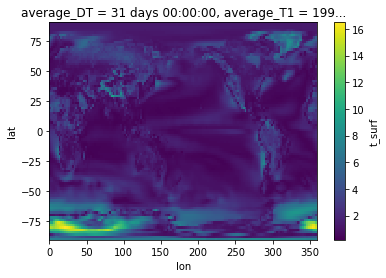

In [181]:
rmse["t_surf"].sel(lead=119).plot()

In [162]:
hindcast.remove_bias(
    how="additive_mean",
    alignment="same_verifs",
    train_test_split="unfair",
)  # .mean(['lat','lon']).plot()

Python 3.9.4 | packaged by conda-forge | (default, May 10 2021, 22:13:33) 
Type 'copyright', 'credits' or 'license' for more information
IPython 7.24.0 -- An enhanced Interactive Python. Type '?' for help.



In [1]:  verif_dates


Out[1]: 
{11: CFTimeIndex([1991-04-01 00:00:00, 1991-10-01 00:00:00, 1992-04-01 00:00:00,
              1992-10-01 00:00:00, 1993-04-01 00:00:00, 1993-10-01 00:00:00,
              1994-04-01 00:00:00, 1994-10-01 00:00:00, 1995-04-01 00:00:00,
              1995-10-01 00:00:00, 1996-04-01 00:00:00, 1996-10-01 00:00:00,
              1997-04-01 00:00:00, 1997-10-01 00:00:00, 1998-04-01 00:00:00,
              1998-10-01 00:00:00, 1999-04-01 00:00:00, 1999-10-01 00:00:00,
              2000-04-01 00:00:00, 2000-10-01 00:00:00, 2001-04-01 00:00:00,
              2001-10-01 00:00:00, 2002-04-01 00:00:00, 2002-10-01 00:00:00,
              2003-04-01 00:00:00, 2003-10-01 00:00:00, 2004-04-01 00:00:00,
              2004-10-01 00:00:00, 2005-04-01 00:00:00, 2005-10-01 00:00:00,
              2006-04-01 00:00:00, 2006-10-01 00:00:00, 2007-04-01 00:00:00,
              2007-10-01 00:00:00, 2008-04-01 00:00:00, 2008-10-01 00:00:00,
              2009-04-01 00:00:00, 2009-10-01 00:00:00, 2010-04

In [2]:  exit()


NotImplementedError: Can not use auto rechunking with object dtype. We are unable to estimate the size in bytes of object data

# Why does this fail?

`climpred.utils.add_time_from_init_lead` does not work: issue opened here: https://github.com/pangeo-data/climpred/issues/698

In [29]:
import climpred
import numpy as np
import xarray as xr

# Hindcasts initialised every 6 months with yearly lead
init = xr.cftime_range(start="2000-01-01", end="2002-01-01", freq="MS")
lead = range(1, 4)
data = np.random.random((len(init), len(lead)))
hind = xr.DataArray(data, coords=[init, lead], dims=["init", "lead"], name="var")
hind["lead"].attrs["units"] = "seasons"

# Add "valid_time" coordinate using `climpred.utils.add_time_from_init_lead()`
hind = climpred.utils.add_time_from_init_lead(hind)
print(hind["valid_time"])

<xarray.DataArray 'valid_time' (lead: 3, init: 25)>
array([[cftime.DatetimeGregorian(2000, 4, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2000, 4, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2000, 4, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2000, 7, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2000, 7, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2000, 7, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2000, 10, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2000, 10, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2000, 10, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2001, 1, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2001, 1, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2001, 1, 1, 0, 0, 0, 0, has_year_zero=False

Also, the "same_verifs" alignment generates a list of times from `verif` that are present in `forecast` at any init but all leads. This list will always be empty when the init frequency is lower than the lead frequency. Is there scope to extend "same_verifs" to instead deal appropriately with such cases? I'll give a concrete example of what I mean below.

Consider the following hindcasts:

In [2]:
import cftime
import climpred
import numpy as np
import xarray as xr

# Hindcasts initialised every year with monthly lead
init = xr.cftime_range(start="2000-01-01", end="2002-01-01", freq="AS")
lead = range(0, 24)
data = np.random.random((len(init), len(lead)))
hind = xr.DataArray(data, coords=[init, lead], dims=["init", "lead"], name="var")
hind["lead"].attrs["units"] = "months"
hind = climpred.utils.add_time_from_init_lead(hind)

I currently can't use "same_verifs" with this data because there are no common times available at all leads.

But, users may still want to align based on a common verification period. In this example, "valid_time"s [2001-01-01 and 2002-01-01] are available at all possible leads for which they can occur (leads 0 and 12 months). Similarly, [2001-02-01 and 2002-02-01] are available at leads 1 and 13 months, [2001-03-01 and 2002-03-01] are available at leads 2 and 14 months... [2001-12-01 and 2002-12-01] are available at leads 11 and 23 months.

That is, by performing verification over the period 2001-01-01 - 2002-12-01 one includes:
- the same dates at each lead, where possible
- the same number of samples at each lead

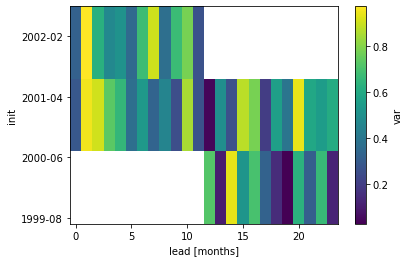

In [3]:
period = [cftime.DatetimeGregorian(2001, 1, 1), cftime.DatetimeGregorian(2002, 12, 1)]

hind.where(
    np.logical_and(hind["valid_time"] >= period[0], hind["valid_time"] <= period[1])
).plot()

How do folks feel about trying to restructure `cftime.utils._same_verifs_alignment()` use the above alignment dates in the above example? We would obviously do this such that the current behaviour is preserved for datasets that have common verification times across all leads.

In [96]:
hind.isel(lead=-1).valid_time

<xarray.DataArray 'valid_time' (init: 5)>
array([cftime.DatetimeGregorian(2001, 6, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2001, 9, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2001, 12, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2002, 3, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2002, 6, 1, 0, 0, 0, 0, has_year_zero=False)],
      dtype=object)
Coordinates:
  * init        (init) object 2000-01-01 00:00:00 ... 2001-01-01 00:00:00
    lead        int64 17
    valid_time  (init) object 2001-06-01 00:00:00 ... 2002-06-01 00:00:00
Attributes:
    long_name:      validity time
    standard_name:  time
    description:    time for which the forecast is valid
    calculate:      init + lead

In [22]:
N_LEAD = 12
N_INIT = 4
N_MEMBER = 1
INIT_FREQ = "MS"
LEAD_UNITS = "seasons"

init = xr.cftime_range(start="2000-01-01", periods=N_INIT, freq=INIT_FREQ)
lead = range(N_LEAD)
member = range(N_MEMBER)
data = np.random.random(
    (
        len(init),
        len(lead),
        len(member),
    )
)
hind = xr.DataArray(
    data, coords=[init, lead, member], dims=["init", "lead", "member"], name="var"
)
hind["lead"].attrs["units"] = LEAD_UNITS

In [23]:
time = xr.cftime_range(start="2000-01-01", end="2020-01-01", freq="MS")
data = np.random.random((len(time),))
obs = xr.DataArray(data, coords=[time], dims=["time"], name="var")

In [24]:
hindcast = HindcastEnsemble(hind)
hindcast = hindcast.add_observations(obs)

In [25]:
hind

<xarray.DataArray 'var' (init: 4, lead: 12, member: 1)>
array([[[0.54144663],
        [0.66904845],
        [0.91749193],
        [0.63214365],
        [0.68733282],
        [0.11864336],
        [0.97551382],
        [0.12495922],
        [0.85152013],
        [0.99807666],
        [0.41124309],
        [0.39181909]],

       [[0.71980423],
        [0.74272177],
        [0.97659812],
        [0.60581274],
        [0.07494726],
        [0.73566343],
        [0.57162996],
...
        [0.74410831],
        [0.94208463],
        [0.4510831 ],
        [0.5425994 ],
        [0.28562122],
        [0.08264346],
        [0.93769972]],

       [[0.1748957 ],
        [0.70713425],
        [0.42543921],
        [0.90540383],
        [0.41789119],
        [0.46219138],
        [0.7043307 ],
        [0.16657152],
        [0.09681265],
        [0.03574377],
        [0.12381093],
        [0.59827523]]])
Coordinates:
  * init     (init) object 2000-01-01 00:00:00 ... 2000-04-01 00:00:00
  * lead     (lead) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * member   (member) int64 0

In [26]:
obs

<xarray.DataArray 'var' (time: 241)>
array([0.37752062, 0.95460547, 0.38204115, 0.31314914, 0.92194664,
       0.64657256, 0.53725517, 0.12291584, 0.96916604, 0.36277988,
       0.61851365, 0.7537338 , 0.56669241, 0.44768371, 0.82557689,
       0.47140051, 0.52549738, 0.58217009, 0.49263769, 0.11562466,
       0.97957095, 0.63297069, 0.39164867, 0.79359721, 0.56204885,
       0.02061311, 0.35239929, 0.26737541, 0.16127904, 0.64155635,
       0.52762899, 0.94933615, 0.19137846, 0.86137227, 0.73669599,
       0.06455336, 0.23312301, 0.86072369, 0.94932701, 0.25208019,
       0.09224607, 0.5665481 , 0.85122954, 0.59094464, 0.70553157,
       0.0122739 , 0.63861019, 0.26284126, 0.39655066, 0.35538334,
       0.81865549, 0.26227138, 0.62114251, 0.15537506, 0.67468754,
       0.5271349 , 0.41848248, 0.58701655, 0.51405526, 0.3680225 ,
       0.85240982, 0.74930019, 0.01787711, 0.58237501, 0.05131743,
       0.10333228, 0.9622511 , 0.07627341, 0.00203591, 0.61876593,
       0.7230973 , 0.82143748, 0.16662854, 0.34639961, 0.46084646,
       0.46176265, 0.08014773, 0.28659329, 0.12634483, 0.90097068,
       0.14448222, 0.26285697, 0.03592824, 0.68772431, 0.61957715,
       0.15004523, 0.63420339, 0.30987887, 0.60421987, 0.46788115,
       0.83727778, 0.91595819, 0.85537811, 0.21140361, 0.83989837,
       0.63460233, 0.71571159, 0.42009682, 0.19144974, 0.30475115,
...
       0.44966719, 0.53704206, 0.87490688, 0.97097114, 0.83558484,
       0.38331397, 0.50157837, 0.81618363, 0.916146  , 0.07994578,
       0.61517016, 0.47226786, 0.94722848, 0.05678799, 0.28255389,
       0.88536065, 0.00251698, 0.11847429, 0.49555373, 0.11123324,
       0.48499846, 0.95841982, 0.96572454, 0.872982  , 0.18045605,
       0.77143465, 0.23427918, 0.48834729, 0.45275585, 0.84351744,
       0.40706963, 0.90959248, 0.37971044, 0.2493755 , 0.11038839,
       0.59805037, 0.02286502, 0.08715644, 0.56589771, 0.54073473,
       0.3733233 , 0.48170482, 0.87525937, 0.50880686, 0.76794057,
       0.26034554, 0.52338374, 0.92554979, 0.221161  , 0.19701517,
       0.5890258 , 0.2739623 , 0.99717928, 0.36380137, 0.35615313,
       0.63465954, 0.19762139, 0.53130057, 0.89880828, 0.26225154,
       0.20841019, 0.24020364, 0.16007738, 0.54479091, 0.39404393,
       0.36206807, 0.51573993, 0.98411141, 0.33696675, 0.67707841,
       0.9853252 , 0.84540128, 0.8504817 , 0.68738735, 0.28957642,
       0.66218842, 0.04724086, 0.35107197, 0.05063898, 0.34404718,
       0.0302472 , 0.18315762, 0.50945319, 0.2337988 , 0.22403024,
       0.51737465, 0.65027949, 0.16595005, 0.6665585 , 0.72884227,
       0.6318273 , 0.633769  , 0.83807691, 0.64485601, 0.30859164,
       0.30765394])
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2020-01-01 00:00:00

In [27]:
result = hindcast.verify(
    metric="rmse",
    comparison="e2o",
    dim="init",
    alignment="same_verif",
)

Python 3.9.4 | packaged by conda-forge | (default, May 10 2021, 22:13:33) 
Type 'copyright', 'credits' or 'license' for more information
IPython 7.24.0 -- An enhanced Interactive Python. Type '?' for help.



In [1]:  init_lead_matrix


Out[1]: 
<xarray.DataArray (lead: 12, time: 4)>
array([[cftime.DatetimeGregorian(2000, 1, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2000, 4, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2000, 4, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2000, 4, 1, 0, 0, 0, 0, has_year_zero=False)],
       [cftime.DatetimeGregorian(2000, 4, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2000, 4, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2000, 4, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2000, 7, 1, 0, 0, 0, 0, has_year_zero=False)],
       [cftime.DatetimeGregorian(2000, 7, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2000, 7, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2000, 7, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2000, 10, 1, 0, 0, 0, 0, has_year_zero=False)],


In [2]:  exit()


CoordinateError: A common set of verification dates cannot be found for the initializations and verification data supplied. Change `alignment` to 'same_inits' or 'maximize'.

In [114]:
result["var"].plot()

<Figure size 432x288 with 1 Axes>


In [192]:
acc = hindcast.verify(metric='acc', comparison='e2o', dim='init', alignment='same_init')

CPU times: user 1.51 s, sys: 91.4 ms, total: 1.6 s
Wall time: 5.93 s


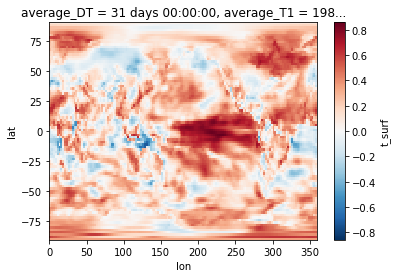

In [200]:
%%time
acc['t_surf'].isel(lead=0).plot()

In [196]:
cafe_hcst

<xarray.DataArray 't_surf' (init: 80, lead: 120, member: 96, lat: 90, lon: 144)>
dask.array<concatenate, shape=(80, 120, 96, 90, 144), dtype=float32, chunksize=(1, 24, 96, 90, 144), chunktype=numpy.ndarray>
Coordinates:
    area        (lat, lon) float32 dask.array<chunksize=(90, 144), meta=np.ndarray>
    average_DT  (lead) timedelta64[ns] dask.array<chunksize=(24,), meta=np.ndarray>
    average_T1  (lead) datetime64[ns] dask.array<chunksize=(24,), meta=np.ndarray>
    average_T2  (lead) datetime64[ns] dask.array<chunksize=(24,), meta=np.ndarray>
  * member      (member) int64 1 2 3 4 5 6 7 8 9 ... 88 89 90 91 92 93 94 95 96
  * lat         (lat) float64 -89.49 -87.98 -85.96 -83.93 ... 85.96 87.98 89.49
  * lon         (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lead        (lead) int64 0 1 2 3 4 5 6 7 ... 112 113 114 115 116 117 118 119
    zsurf       (lat, lon) float32 dask.array<chunksize=(90, 144), meta=np.ndarray>
  * init        (init) object 1981-05-16 12:00:00 ... 2020-11-16 00:00:00
Attributes:
    cell_methods:   time: mean
    long_name:      surface temperature
    time_avg_info:  average_T1,average_T2,average_DT
    units:          deg_k
    valid_range:    [100.0, 400.0]